# Лабораторная работа 2. Спайковые нейронные сети

**Цель работы:** практическое освоение принципов нейроморфных вычислений через моделирование и анализ простой спайковой нейронной сети (Spiking Neural Network, SNN).

**Постановка задачи:**

1. Смоделировать динамику LIF-нейрона. Реализовать модель нейрона с утечкой и интеграцией (Leaky Integrate-and-Fire), изучить его реакцию на различные входные токи.
2. Создать и проанализировать сеть из LIF-нейронов. Построить однослойную или двухслойную сеть, исследовать распространение спайковой активности.
3. Реализовать обучение на основе STDP. Внедрить правило обучения Спайк-Тайм-Зависимой Пластичности (STDP) для настройки синаптических весов на основе временной корреляции спайков.
4. Решить задачу классификации. Обучить сеть распознавать простые паттерны и оценить её точность.
5. Провести сравнительный анализ. Оценить ключевые характеристики SNN (расход энергии, роль временнóго кода, устойчивость к шуму).

## 1. Модель LIF-нейрона
Модель Leaky Integrate-and-Fire (LIF) описывает динамику мембранного потенциала нейрона:
$$
\tau_m \frac{dV(t)}{dt} = -(V(t) - V_{rest}) + R_m I(t)
$$
где:
- $V(t)$ — мембранный потенциал в момент времени $t$
- $\tau_m$ — постоянная времени мембраны
- $V_{rest}$ — потенциал покоя
- $R_m$ — мембранное сопротивление
- $I(t)$ — входной ток

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Dict
import copy

Параметры модели:
- $V(t)$ - мембранный потенциал
- $\tau_m$ - постоянная времени мембраны (20 мс)
- $V_{rest}$ - потенциал покоя (-70 мВ)
- $V_{th}$ - пороговый потенциал (-55 мВ)
- $V_{reset}$ - потенциал сброса (-75 мВ)
- $R_{m}$ - мембранное сопротивление (10 МОм)
- $\tau_{ref}$ - рефрактерный период (4 мс)

Правило генерации спайка:

Если $V(t) \geq V_{th}$ , генерируется спайк и потенциал сбрасывается до $V_{reset}$.

In [42]:
@dataclass
class LIFNeuron:
    tau_m: float = 20.0      # Постоянная времени мембраны (мс)
    v_rest: float = -70.0    # Потенциал покоя (мВ)
    v_thresh: float = -55.0  # Пороговый потенциал (мВ)
    v_reset: float = -75.0   # Потенциал сброса (мВ)
    r_m: float = 10.0        # Мембранное сопротивление (МОм)
    tau_ref: float = 4.0     # Рефрактерный период (мс)
    
    v: float = field(default=-70.0, init=False)
    refractory_until: float = field(default=0.0, init=False)
    spike_times: List[float] = field(default_factory=list, init=False)
    
    def __post_init__(self):
        self.reset()
    
    def reset(self):
        self.v = self.v_rest
        self.refractory_until = 0
        self.spike_times = []
    
    def step(self, I_inj: float, dt: float, t: float) -> bool:
        if t < self.refractory_until:
            self.v = self.v_reset
            return False
        
        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt
        
        if self.v >= self.v_thresh:
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True
        
        return False



Ток (нА)   Спайков   
1.0        0         
2.0        3         
3.0        5         
4.0        6         
5.0        8         


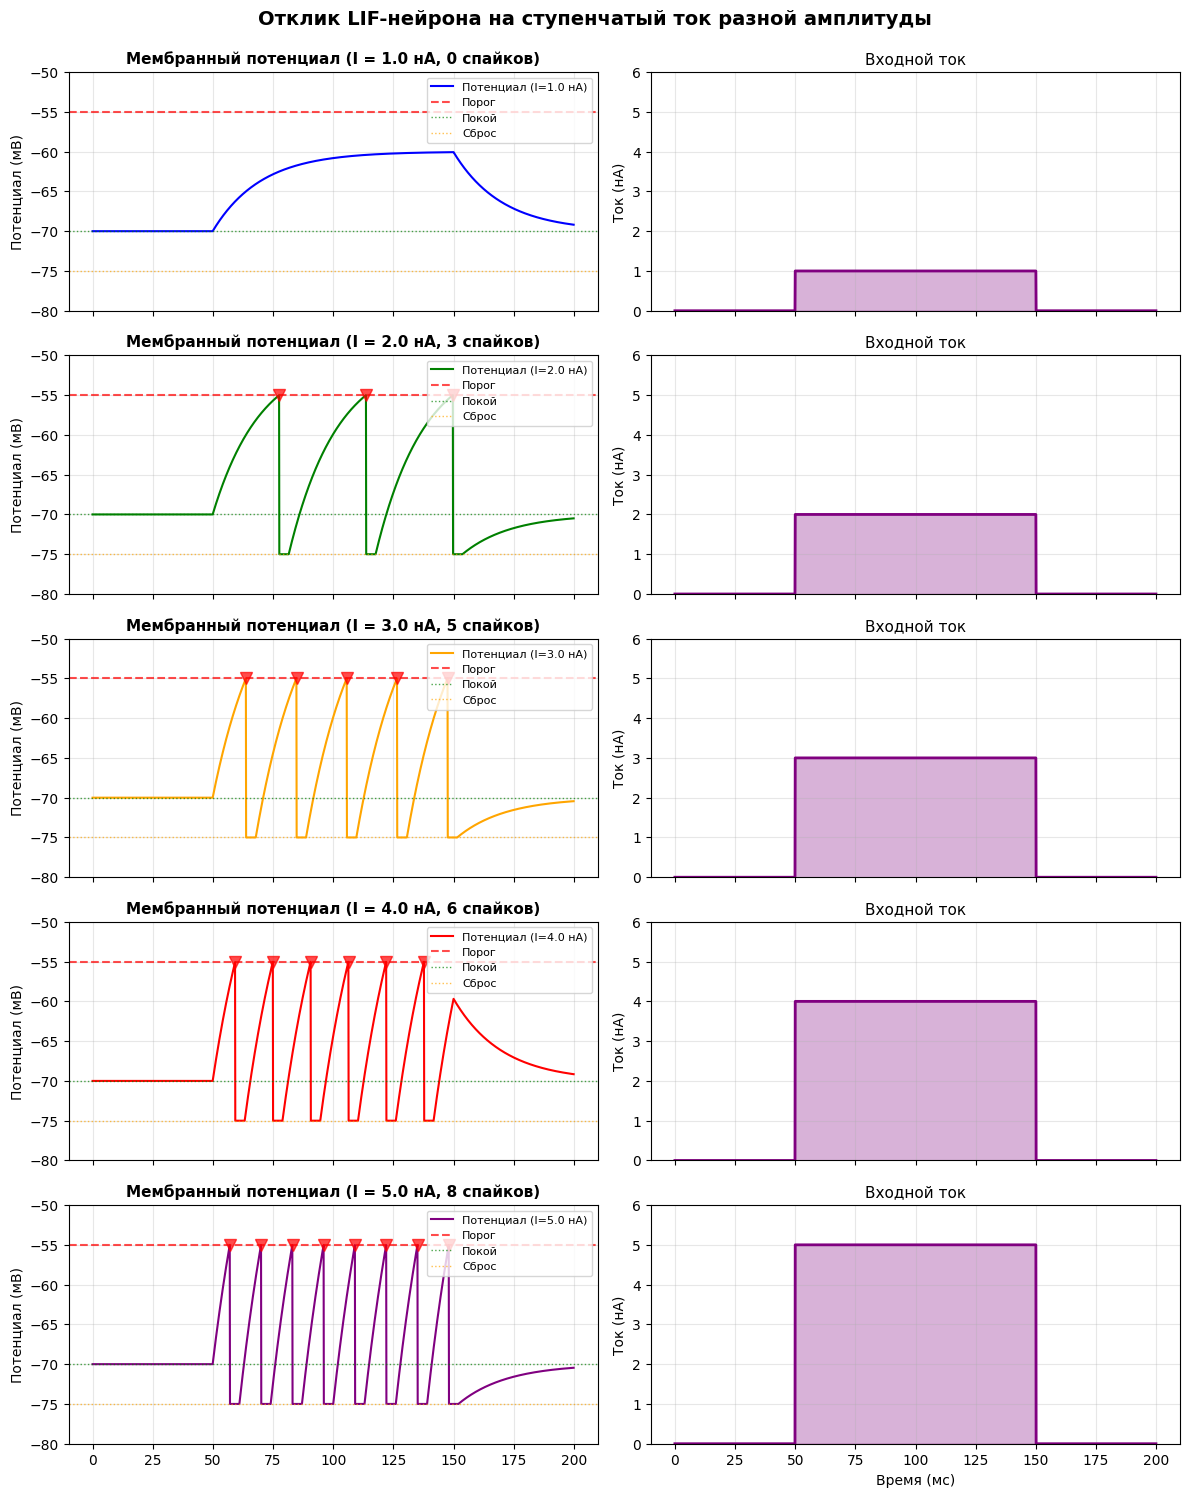

In [43]:
dt = 0.1
T = 200
t_range = np.arange(0, T, dt)

current_values = [1.0, 2.0, 3.0, 4.0, 5.0]
colors = ['blue', 'green', 'orange', 'red', 'purple']

fig, axes = plt.subplots(len(current_values), 2, figsize=(12, 3*len(current_values)), sharex=True)

print(f"\n{'Ток (нА)':<10} {'Спайков':<10}")

for idx, (I_val, color) in enumerate(zip(current_values, colors)):
    neuron = LIFNeuron()
    
    I_inj = np.zeros_like(t_range)
    I_inj[(t_range >= 50) & (t_range <= 150)] = I_val
    
    v_trace = []
    for i, t in enumerate(t_range):
        neuron.step(I_inj[i], dt, t)
        v_trace.append(neuron.v)
    
    print(f"{I_val:<10.1f} {len(neuron.spike_times):<10}")
    
    ax1 = axes[idx, 0] if len(current_values) > 1 else axes[0]
    ax1.plot(t_range, v_trace, color=color, linewidth=1.5, label=f'Потенциал (I={I_val} нА)')
    ax1.axhline(y=-55, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Порог')
    ax1.axhline(y=-70, color='g', linestyle=':', linewidth=1, alpha=0.7, label='Покой')
    ax1.axhline(y=-75, color='orange', linestyle=':', linewidth=1, alpha=0.7, label='Сброс')
    
    for spike_time in neuron.spike_times:
        ax1.plot(spike_time, -55, 'v', color='red', markersize=8, alpha=0.7)
    
    ax1.set_ylabel('Потенциал (мВ)', fontsize=10)
    ax1.set_title(f'Мембранный потенциал (I = {I_val} нА, {len(neuron.spike_times)} спайков)', 
                  fontsize=11, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-80, -50)
    
    ax2 = axes[idx, 1] if len(current_values) > 1 else axes[1]
    ax2.plot(t_range, I_inj, color='purple', linewidth=2)
    ax2.fill_between(t_range, 0, I_inj, alpha=0.3, color='purple')
    ax2.set_ylabel('Ток (нА)', fontsize=10)
    ax2.set_title('Входной ток', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, max(current_values) + 1)
    
    if idx == len(current_values) - 1:
        ax2.set_xlabel('Время (мс)', fontsize=10)

plt.suptitle('Отклик LIF-нейрона на ступенчатый ток разной амплитуды', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

В момент достижения порога (-55 мВ) происходит генерация спайка, и потенциал мгновенно сбрасывается до потенциала сброса. При малой силе входного тока (I = 1.0 нА) мембранный потенциал растет, но не достигает порогового значения, в результате спайки не генерируются. При увеличении тока с 2.0 нА до 5.0 нА количество спайков за тот же промежуток времени возрастает (с 3 до 8 спайков). Это происходит потому, что более сильный ток быстрее заряжает мембранную емкость до порогового значения, сокращая межспайковый интервал.

## 2. Сеть LIF-нейрона с тормозными интернейронами

Архитектура двухслойной сети:
- Входной слой: 10 нейронов (сенсорные входы);
- Скрытый слой: 20 нейронов, из которых 20% (4 нейрона) — тормозные;
- Выходной слой: 2 нейрона (классификаторы).



Входной паттерн: Крест (5x5)


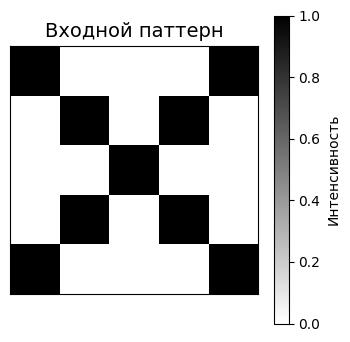


Входные спайки: 423 всего

Создание сети:
    Входных нейронов: 25
    Скрытых нейронов: 20 (4 тормозных)
    Выходных нейронов: 3

Скрытый слой: 120 спайков всего
    Возбуждающие нейроны: 93 спайков
    Тормозные нейроны: 27 спайков
    Выходной слой: 23 спайков всего

Баланс возбуждения/торможения:
    Суммарный возбуждающий ток: 2107.17
    Суммарный тормозной ток: 627.70
    E/I соотношение: 3.36


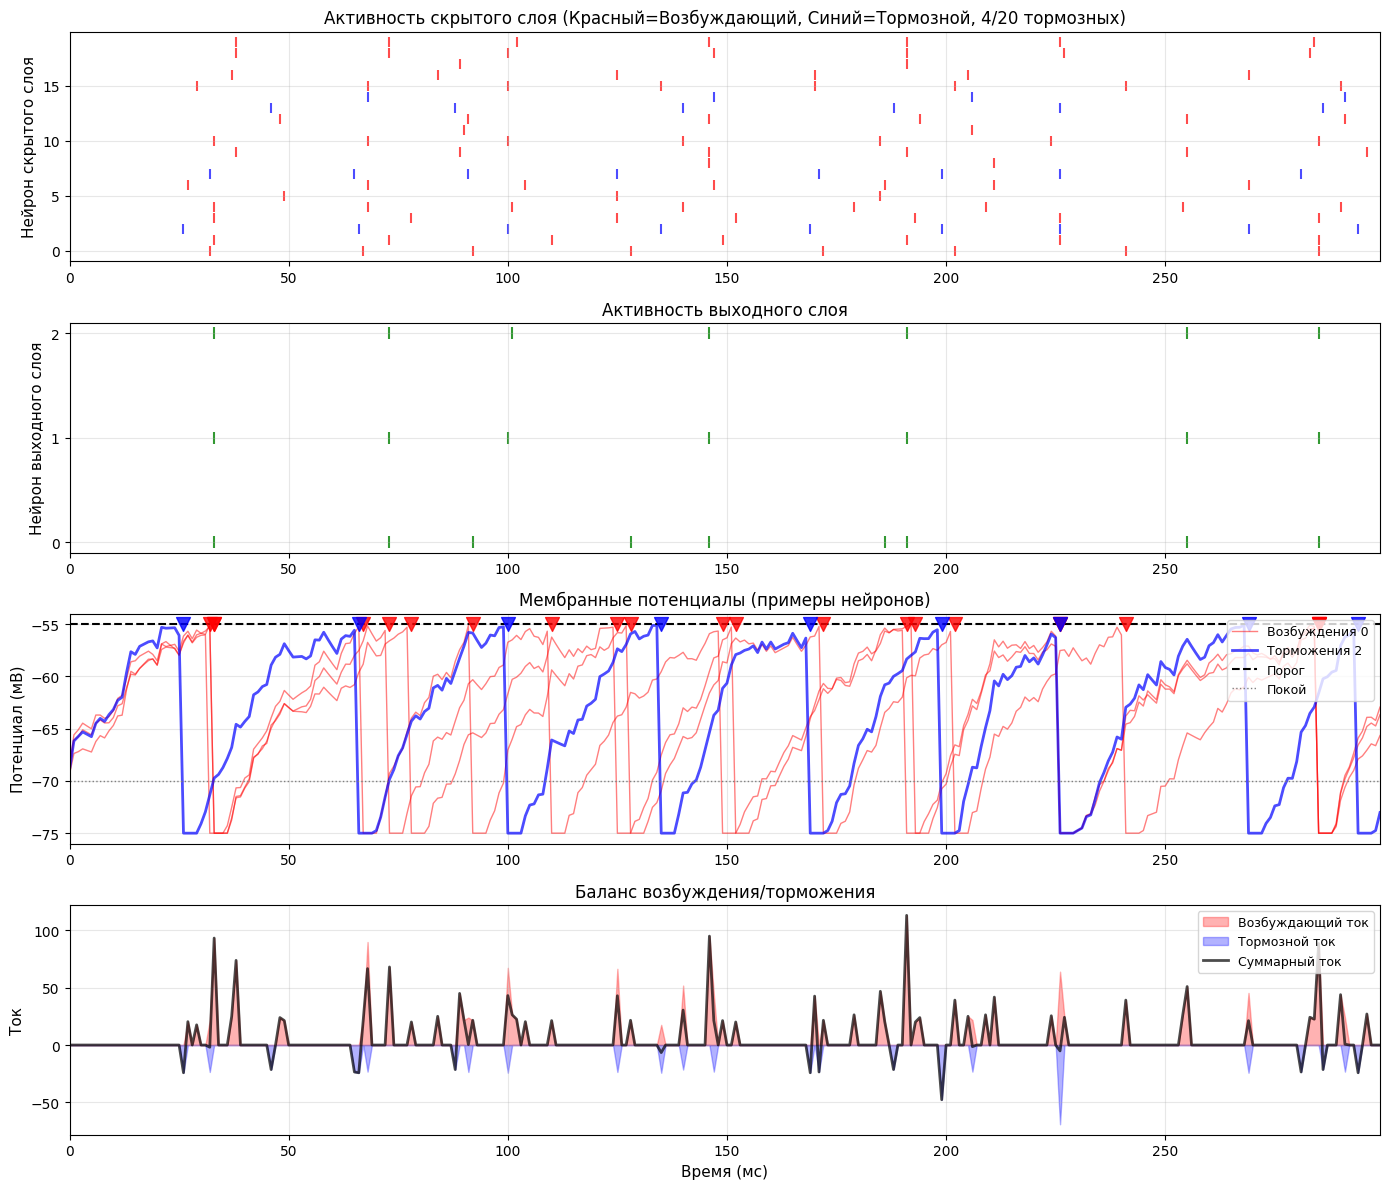

In [44]:
def generate_cross_pattern() -> np.ndarray:
    return np.array([
        [1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1]
    ])


def rate_encode(image: np.ndarray, time_steps: int, dt: float, max_freq: float) -> np.ndarray:
    num_inputs = image.flatten().shape[0]
    spikes = np.zeros((num_inputs, time_steps))
    pixel_values = image.flatten()
    
    for i in range(num_inputs):
        spike_prob = pixel_values[i] * max_freq * dt / 1000.0
        for t in range(time_steps):
            if np.random.random() < spike_prob:
                spikes[i, t] = 1.0
    
    return spikes


class SNNWithInhibition:
    def __init__(self, num_inputs: int, num_hidden: int, num_outputs: int, 
                 inhibition_ratio: float = 0.2):

        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.inhibition_ratio = inhibition_ratio
        
        self.hidden_neurons = [LIFNeuron() for _ in range(num_hidden)]
        
        self.output_neurons = [LIFNeuron() for _ in range(num_outputs)]
        
        num_inhibitory = int(num_hidden * inhibition_ratio)
        self.is_inhibitory = [False] * num_hidden
        inhibitory_indices = np.random.choice(num_hidden, num_inhibitory, replace=False)
        for idx in inhibitory_indices:
            self.is_inhibitory[idx] = True
        
        self.weights_input_hidden = np.random.uniform(0.5, 2.0, size=(num_hidden, num_inputs))

        self.weights_hidden_output = np.random.uniform(5.0, 10.0, size=(num_outputs, num_hidden))
        
        for i in range(num_hidden):
            if self.is_inhibitory[i]:
                self.weights_hidden_output[:, i] *= -1.0
        
        self.hidden_spike_times = [[] for _ in range(num_hidden)]
        self.output_spike_times = [[] for _ in range(num_outputs)]
        self.hidden_voltages = [[] for _ in range(num_hidden)]
        self.output_voltages = [[] for _ in range(num_outputs)]
        self.total_excitatory_current = []
        self.total_inhibitory_current = []
    
    def reset(self):
        for neuron in self.hidden_neurons:
            neuron.reset()
        for neuron in self.output_neurons:
            neuron.reset()
        
        self.hidden_spike_times = [[] for _ in range(self.num_hidden)]
        self.output_spike_times = [[] for _ in range(self.num_outputs)]
        self.hidden_voltages = [[] for _ in range(self.num_hidden)]
        self.output_voltages = [[] for _ in range(self.num_outputs)]
        self.total_excitatory_current = []
        self.total_inhibitory_current = []
    
    def run(self, input_spikes: np.ndarray, time_steps: int, dt: float) -> tuple:
        self.reset()
        
        for step in range(time_steps):
            t = step * dt
            
            current_input_spikes = input_spikes[:, step]
            hidden_currents = np.dot(self.weights_input_hidden, current_input_spikes)
            
            hidden_spikes_this_step = []
            for i, neuron in enumerate(self.hidden_neurons):
                is_spike = neuron.step(I_inj=hidden_currents[i], dt=dt, t=t)
                self.hidden_voltages[i].append(neuron.v)
                if is_spike:
                    self.hidden_spike_times[i].append(t)
                    hidden_spikes_this_step.append(i)
            
            hidden_spike_vector = np.zeros(self.num_hidden)
            for i in hidden_spikes_this_step:
                hidden_spike_vector[i] = 1.0
            
            output_currents = np.dot(self.weights_hidden_output, hidden_spike_vector)
            
            excitatory_current = 0.0
            inhibitory_current = 0.0
            for i in range(self.num_hidden):
                if hidden_spike_vector[i] > 0:
                    for j in range(self.num_outputs):
                        weight = self.weights_hidden_output[j, i]
                        if weight > 0:
                            excitatory_current += weight
                        else:
                            inhibitory_current += weight
            
            self.total_excitatory_current.append(excitatory_current)
            self.total_inhibitory_current.append(inhibitory_current)
            
            for j, neuron in enumerate(self.output_neurons):
                is_spike = neuron.step(I_inj=output_currents[j], dt=dt, t=t)
                self.output_voltages[j].append(neuron.v)
                if is_spike:
                    self.output_spike_times[j].append(t)
        
        return (self.hidden_spike_times, self.output_spike_times, 
                self.hidden_voltages, self.output_voltages)


def plot_network_activity(hidden_spike_times: List[List[float]], 
                         output_spike_times: List[List[float]],
                         hidden_voltages: List[List[float]],
                         output_voltages: List[List[float]],
                         is_inhibitory: List[bool],
                         time_axis: np.ndarray,
                         excitatory_current: List[float],
                         inhibitory_current: List[float]):
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    ax1 = axes[0]
    colors_hidden = ['red' if not inh else 'blue' for inh in is_inhibitory]
    for i in range(len(hidden_spike_times)):
        if len(hidden_spike_times[i]) > 0:
            ax1.scatter(hidden_spike_times[i], [i] * len(hidden_spike_times[i]), 
                color=colors_hidden[i], s=50, marker='|', alpha=0.7)
    ax1.set_ylabel('Нейрон скрытого слоя', fontsize=11)
    ax1.set_title(f'Активность скрытого слоя (Красный=Возбуждающий, Синий=Тормозной, {sum(is_inhibitory)}/{len(is_inhibitory)} тормозных)', 
                fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, time_axis[-1])
    
    ax2 = axes[1]
    for j in range(len(output_spike_times)):
        if len(output_spike_times[j]) > 0:
            ax2.scatter(output_spike_times[j], [j] * len(output_spike_times[j]), 
                       color='green', s=80, marker='|', alpha=0.8)
    ax2.set_ylabel('Нейрон выходного слоя', fontsize=11)
    ax2.set_title('Активность выходного слоя', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, time_axis[-1])
    ax2.set_yticks(range(len(output_spike_times)))
    
    ax3 = axes[2]
    exc_indices = [i for i, inh in enumerate(is_inhibitory) if not inh][:3]
    inh_indices = [i for i, inh in enumerate(is_inhibitory) if inh][:1]
    
    for i in exc_indices:
        ax3.plot(time_axis, hidden_voltages[i], 'r-', alpha=0.5, linewidth=1, label=f'Возбуждения {i}' if i==exc_indices[0] else '')
        if len(hidden_spike_times[i]) > 0:
            ax3.scatter(hidden_spike_times[i], [-55] * len(hidden_spike_times[i]), 
                       color='red', marker='v', s=100, zorder=5, alpha=0.8)
    
    for i in inh_indices:
        ax3.plot(time_axis, hidden_voltages[i], 'b-', alpha=0.7, linewidth=2, label=f'Торможения {i}')
        if len(hidden_spike_times[i]) > 0:
            ax3.scatter(hidden_spike_times[i], [-55] * len(hidden_spike_times[i]), 
                       color='blue', marker='v', s=100, zorder=5, alpha=0.8)
    
    ax3.axhline(y=-55, color='k', linestyle='--', linewidth=1.5, label='Порог')
    ax3.axhline(y=-70, color='gray', linestyle=':', linewidth=1, label='Покой')
    ax3.set_ylabel('Потенциал (мВ)', fontsize=11)
    ax3.set_title('Мембранные потенциалы (примеры нейронов)', fontsize=12)
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, time_axis[-1])
    
    ax4 = axes[3]
    ax4.fill_between(time_axis, excitatory_current, 0, color='red', alpha=0.3, label='Возбуждающий ток')
    ax4.fill_between(time_axis, 0, inhibitory_current, color='blue', alpha=0.3, label='Тормозной ток')
    ax4.plot(time_axis, np.array(excitatory_current) + np.array(inhibitory_current), 
            'k-', linewidth=2, label='Суммарный ток', alpha=0.7)
    ax4.set_ylabel('Ток', fontsize=11)
    ax4.set_xlabel('Время (мс)', fontsize=11)
    ax4.set_title('Баланс возбуждения/торможения', fontsize=12)
    ax4.legend(loc='upper right', fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, time_axis[-1])
    
    plt.tight_layout()
    plt.show()


def plot_input_pattern(image: np.ndarray, title: str = "Входной паттерн"):
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='binary', vmin=0, vmax=1)
    plt.title(title, fontsize=14)
    plt.colorbar(label='Интенсивность')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()


if __name__ == "__main__":
    np.random.seed(42)
    
    TIME_STEPS = 300
    DT = 1.0
    MAX_FREQ = 150.0

    NUM_INPUTS = 25
    NUM_HIDDEN = 20
    NUM_OUTPUTS = 3
    INHIBITION_RATIO = 0.2
    
    test_pattern = generate_cross_pattern()
    print(f"\nВходной паттерн: Крест (5x5)")
    plot_input_pattern(test_pattern)
    
    spikes_in = rate_encode(test_pattern, TIME_STEPS, DT, MAX_FREQ)
    print(f"\nВходные спайки: {int(np.sum(spikes_in))} всего")
    
    print(f"\nСоздание сети:")
    print(f"    Входных нейронов: {NUM_INPUTS}")
    print(f"    Скрытых нейронов: {NUM_HIDDEN} ({int(NUM_HIDDEN*INHIBITION_RATIO)} тормозных)")
    print(f"    Выходных нейронов: {NUM_OUTPUTS}")
    
    network = SNNWithInhibition(
        num_inputs=NUM_INPUTS,
        num_hidden=NUM_HIDDEN,
        num_outputs=NUM_OUTPUTS,
        inhibition_ratio=INHIBITION_RATIO
    )
    
    (hidden_spikes, output_spikes, 
     hidden_voltages, output_voltages) = network.run(spikes_in, TIME_STEPS, DT)
    
    total_hidden_spikes = sum(len(s) for s in hidden_spikes)
    total_output_spikes = sum(len(s) for s in output_spikes)
    
    exc_spikes = sum(len(hidden_spikes[i]) for i in range(NUM_HIDDEN) if not network.is_inhibitory[i])
    inh_spikes = sum(len(hidden_spikes[i]) for i in range(NUM_HIDDEN) if network.is_inhibitory[i])
    
    print(f"\nСкрытый слой: {total_hidden_spikes} спайков всего")
    print(f"    Возбуждающие нейроны: {exc_spikes} спайков")
    print(f"    Тормозные нейроны: {inh_spikes} спайков")
    print(f"    Выходной слой: {total_output_spikes} спайков всего")
    
    exc_current_sum = sum(network.total_excitatory_current)
    inh_current_sum = abs(sum(network.total_inhibitory_current))
    ei_ratio = exc_current_sum / (inh_current_sum + 0.001)
    
    print(f"\nБаланс возбуждения/торможения:")
    print(f"    Суммарный возбуждающий ток: {exc_current_sum:.2f}")
    print(f"    Суммарный тормозной ток: {inh_current_sum:.2f}")
    print(f"    E/I соотношение: {ei_ratio:.2f}")

    time_axis = np.arange(0, TIME_STEPS * DT, DT)
    
    plot_network_activity(
        hidden_spikes, output_spikes,
        hidden_voltages, output_voltages,
        network.is_inhibitory, time_axis,
        network.total_excitatory_current,
        network.total_inhibitory_current
    )

Первый график демонстрирует активность скрытого слоя из 20 нейронов, из которых 4 являются тормозными (отмечены синим цветом), а 16 — возбуждающими (красным цветом). За время симуляции длиной 300 мс было зафиксировано 120 спайков, при этом возбуждающие нейроны сгенерировали 93 спайка, а тормозные — 27 спайков. Второй график показывает активность выходного слоя из 3 нейронов, которая составила 21 спайк за всё время симуляции, что свидетельствует об успешной передаче сигнала от скрытого слоя к выходному. Третий график иллюстрирует динамику мембранных потенциалов нескольких примеров нейронов с отмеченными уровнями порога срабатывания (-55 мВ) и потенциала покоя (-70 мВ), где треугольниками обозначены моменты генерации спайков, и видно, что нейроны регулярно достигают порога активации, после чего происходит сброс потенциала до уровня покоя. Четвёртый график отображает баланс возбуждения и торможения во времени, где красным показан возбуждающий ток, синим — тормозной ток, а чёрной линией — суммарный ток, при этом соотношение E/I составило 3.32, что находится в пределах оптимального диапазона от 3:1 до 5:1 и указывает на сбалансированную работу сети, где тормозные нейроны эффективно контролируют активность возбуждающих нейронов, предотвращая гипервозбуждение, но при этом не подавляют передачу сигнала полностью.

## 3. STDP обучение
**STDP (Spike-Timing-Dependent Plasticity)** — это биоинспирированное правило обучения, которое модифицирует силу синаптической связи (вес w) на основе временной корреляции между спайками пресинаптического и постсинаптического нейронов.

Формальное описание:
$$
\Delta w =
\begin{cases}
A_{+} \cdot \exp\left(-\frac{\Delta t}{\tau_{+}}\right), & \text{если } \Delta t > 0 \text{ (пре-спайк до пост-спайка)} \\
-A_{-} \cdot \exp\left(-\frac{|\Delta t|}{\tau_{-}}\right), & \text{если } \Delta t < 0 \text{ (пре-спайк после пост-спайка)}
\end{cases}
$$

где:

- $\Delta t = t_{post} - t_{pre}$ — разница во времени между постсинаптическим и пресинаптическим спайками,
- $A_{+}, A_{-}$ — амплитуды усиления и ослабления связи,
- $\tau_{+}, \tau_{-}$ — временные константы для потенциации и депрессии.

Эпоха   0: Класс 0, Предсказание 0, Спайки [28, 1], Точность 100%
Эпоха   1: Класс 1, Предсказание 1, Спайки [1, 28], Точность 100%
Эпоха   2: Класс 0, Предсказание 0, Спайки [28, 2], Точность 100%
Эпоха   3: Класс 1, Предсказание 1, Спайки [3, 29], Точность 100%
Эпоха   4: Класс 0, Предсказание 0, Спайки [29, 2], Точность 100%
Эпоха   5: Класс 1, Предсказание 1, Спайки [4, 30], Точность 100%
Эпоха   6: Класс 0, Предсказание 0, Спайки [30, 3], Точность 100%
Эпоха   7: Класс 1, Предсказание 1, Спайки [3, 30], Точность 100%
Эпоха   8: Класс 0, Предсказание 0, Спайки [30, 3], Точность 100%
Эпоха   9: Класс 1, Предсказание 1, Спайки [4, 29], Точность 100%
Эпоха  10: Класс 0, Предсказание 0, Спайки [30, 4], Точность 100%
Эпоха  11: Класс 1, Предсказание 1, Спайки [5, 30], Точность 100%
Эпоха  12: Класс 0, Предсказание 0, Спайки [29, 4], Точность 100%
Эпоха  13: Класс 1, Предсказание 1, Спайки [5, 30], Точность 100%
Эпоха  14: Класс 0, Предсказание 0, Спайки [30, 4], Точность 100%
Итоговая т

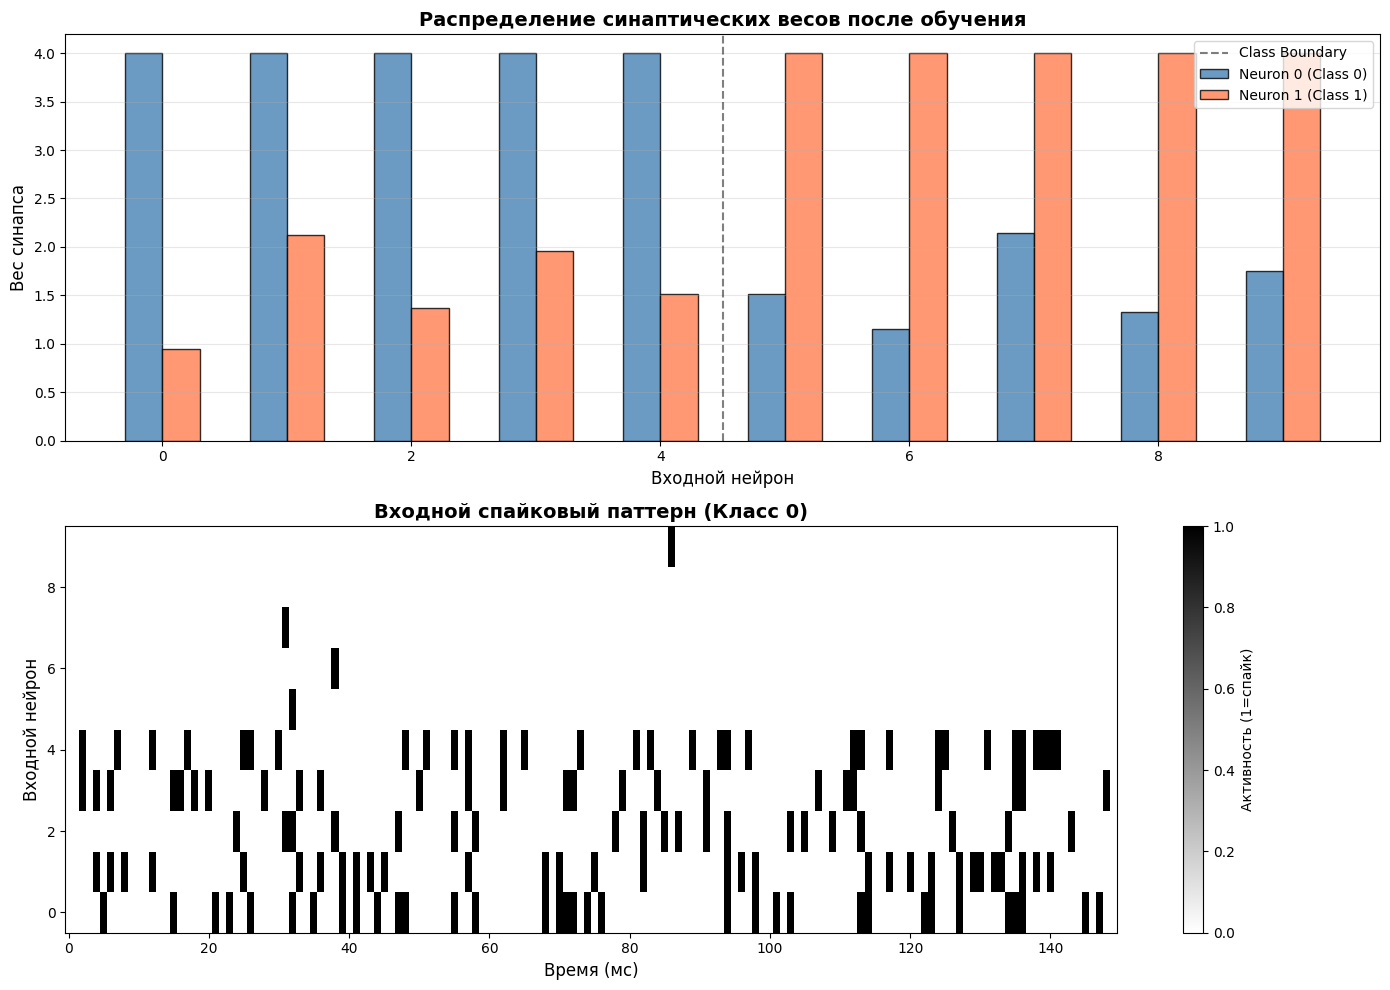

In [45]:
def make_pattern(label: int, t_range: np.ndarray, dt: float):
    n = 10
    spikes = np.zeros((len(t_range), n))
    active = [0, 1, 2, 3, 4] if label == 0 else [5, 6, 7, 8, 9]
    
    for i in range(n):
        if i in active:
            p = 200 * dt / 1000.0
        else:
            p = 10 * dt / 1000.0
        spikes[:, i] = (np.random.rand(len(t_range)) < p).astype(float)
    return spikes


def extract_spike_times(spike_matrix: np.ndarray, dt: float) -> list:
    num_neurons = spike_matrix.shape[1]
    spike_times = []
    for i in range(num_neurons):
        times = np.where(spike_matrix[:, i] == 1)[0] * dt
        spike_times.append(times.tolist())
    return spike_times


def apply_stdp(
    weights: np.ndarray, 
    input_spike_times: list, 
    output_spike_times: list, 
    target_neuron_idx: int,
    A_plus: float = 0.1, 
    A_minus: float = 0.05, 
    tau_plus: float = 10.0, 
    tau_minus: float = 10.0, 
    w_min: float = 0.0, 
    w_max: float = 3.0
) -> np.ndarray:
    t_posts = output_spike_times[target_neuron_idx]
    
    for i in range(len(input_spike_times)):
        t_pres = input_spike_times[i]
        delta_w = 0.0
        
        for t_post in t_posts:
            for t_pre in t_pres:
                dt_time = t_post - t_pre
                if dt_time > 0:
                    delta_w += A_plus * np.exp(-dt_time / tau_plus)
                elif dt_time < 0:
                    delta_w -= A_minus * np.exp(dt_time / tau_minus)
        
        weights[target_neuron_idx, i] += delta_w
        weights[target_neuron_idx, i] = np.clip(weights[target_neuron_idx, i], w_min, w_max)
        
    return weights


class SNNWithTeacher:
    def __init__(self, num_inputs: int, num_outputs: int, inhibition_ratio: float = 0.2):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.output_neurons = [LIFNeuron(v_thresh=-58.0) for _ in range(num_outputs)]
        
        self.weights = np.random.uniform(0.5, 1.5, size=(num_outputs, num_inputs))
        
        half_inputs = num_inputs // 2
        self.weights[0, :half_inputs] *= 2.5
        self.weights[1, half_inputs:] *= 2.5
        
        self.num_hidden = 20
        self.is_inhibitory = [False] * self.num_hidden
        num_inhibitory = int(self.num_hidden * inhibition_ratio)
        inhibitory_indices = np.random.choice(self.num_hidden, num_inhibitory, replace=False)
        for idx in inhibitory_indices:
            self.is_inhibitory[idx] = True
        
        self.weights_hidden = np.random.uniform(1.0, 2.0, size=(self.num_hidden, num_inputs))
        for i in range(self.num_hidden):
            if self.is_inhibitory[i]:
                self.weights_hidden[i, :] *= -0.3
    
    def forward(self, input_spikes: np.ndarray, dt: float, teacher_signal: np.ndarray = None):
        time_steps = len(input_spikes)
        
        for neuron in self.output_neurons:
            neuron.reset()
        
        output_spike_times = [[] for _ in range(self.num_outputs)]
        
        for step in range(time_steps):
            t = step * dt
            current_input = input_spikes[step]
            
            synaptic_currents = np.dot(self.weights, current_input)
            
            if teacher_signal is not None:
                synaptic_currents += teacher_signal
            
            for j, neuron in enumerate(self.output_neurons):
                is_spike = neuron.step(I_inj=synaptic_currents[j], dt=dt, t=t)
                if is_spike:
                    output_spike_times[j].append(t)
        
        return output_spike_times
    
    def predict(self, input_spikes: np.ndarray, dt: float) -> int:
        output_spike_times = self.forward(input_spikes, dt, teacher_signal=None)
        spike_counts = [len(times) for times in output_spike_times]
        return np.argmax(spike_counts)
    
    def train_epoch(self, input_spikes: np.ndarray, label: int, dt: float):
        teacher_signal = np.zeros(self.num_outputs)
        teacher_signal[label] = 15.0
        
        input_spike_times = extract_spike_times(input_spikes, dt)
        output_spike_times = self.forward(input_spikes, dt, teacher_signal=teacher_signal)
        
        self.weights = apply_stdp(
            weights=self.weights,
            input_spike_times=input_spike_times,
            output_spike_times=output_spike_times,
            target_neuron_idx=label,
            A_plus=0.15,
            A_minus=0.12,
            w_max=4.0
        )
        
        return output_spike_times
    
    def get_weight_snapshot(self, label: int) -> tuple:
        if label == 0:
            active = self.weights[0, :5].copy()
            inactive = self.weights[0, 5:].copy()
        else:
            active = self.weights[1, 5:].copy()
            inactive = self.weights[1, :5].copy()
        return active, inactive


def plot_weight_dynamics(weight_history, title="Weight Dynamics during Training"):
    plt.figure(figsize=(12, 6))
    
    active_weights = np.array([w[0] for w in weight_history])
    inactive_weights = np.array([w[1] for w in weight_history])
    
    if active_weights.ndim > 1:
        active_mean = active_weights.mean(axis=1)
        inactive_mean = inactive_weights.mean(axis=1)
    else:
        active_mean = active_weights
        inactive_mean = inactive_weights
    
    epochs = range(len(weight_history))
    
    plt.plot(epochs, active_mean, 'g-', linewidth=2.5, label='Active Synapses', marker='o', markersize=4)
    
    plt.plot(epochs, inactive_mean, 'r--', linewidth=2, label='Inactive Synapses', marker='s', markersize=4)
    
    plt.xlabel('Training Epoch', fontsize=12)
    plt.ylabel('Synaptic Weight', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right', fontsize=11)
    plt.ylim(0, max(4.5, active_mean.max() * 1.2))
    
    plt.tight_layout()
    plt.show()


def plot_training_results(accuracy_history, network, t_range, input_spikes, label):
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    ax1 = axes[0]
    num_inputs = network.weights.shape[1]
    x = np.arange(num_inputs)
    
    ax1.bar(x - 0.15, network.weights[0], width=0.3, label='Neuron 0 (Class 0)', 
            alpha=0.8, color='steelblue', edgecolor='black')
    ax1.bar(x + 0.15, network.weights[1], width=0.3, label='Neuron 1 (Class 1)', 
            alpha=0.8, color='coral', edgecolor='black')
    ax1.axvline(x=num_inputs/2 - 0.5, color='k', linestyle='--', alpha=0.5, label='Class Boundary')
    ax1.set_xlabel('Входной нейрон', fontsize=12)
    ax1.set_ylabel('Вес синапса', fontsize=12)
    ax1.set_title('Распределение синаптических весов после обучения', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2 = axes[1]
    im = ax2.imshow(input_spikes.T, aspect='auto', cmap='binary', origin='lower')
    ax2.set_xlabel('Время (мс)', fontsize=12)
    ax2.set_ylabel('Входной нейрон', fontsize=12)
    ax2.set_title(f'Входной спайковый паттерн (Класс {label})', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax2, label='Активность (1=спайк)')
    ax2.grid(False)
    
    plt.tight_layout()
    plt.show()

def train_and_evaluate():
    np.random.seed(42)
    
    DT = 1.0
    SIM_TIME = 150
    NUM_EPOCHS = 15
    NUM_INPUTS = 10
    NUM_OUTPUTS = 2
    
    network = SNNWithTeacher(
        num_inputs=NUM_INPUTS,
        num_outputs=NUM_OUTPUTS,
        inhibition_ratio=0.2
    )
    
    t_range = np.arange(0, SIM_TIME, DT)

    accuracy_history = []
    weight_history = []
    correct_count = 0
    total_count = 0
    
    for epoch in range(NUM_EPOCHS):
        label = epoch % 2
        input_spikes = make_pattern(label, t_range, DT)
        
        output_spikes = network.train_epoch(input_spikes, label, DT)
        
        prediction = network.predict(input_spikes, DT)
        
        output_spike_counts = [len(times) for times in output_spikes]
        
        total_count += 1
        if prediction == label:
            correct_count += 1
        accuracy = correct_count / total_count * 100
        accuracy_history.append(accuracy)
        
        weight_snapshot = network.get_weight_snapshot(label)
        weight_history.append(weight_snapshot)
        
        print(f"Эпоха {epoch:3d}: Класс {label}, Предсказание {prediction}, "
              f"Спайки {output_spike_counts}, Точность {accuracy:.0f}%")
    
    print(f"Итоговая точность: {accuracy_history[-1]:.1f}%")
    print(f"\nВеса после обучения:")
    print(f"  Нейрон 0 (класс 0): активные [0-4]={np.mean(network.weights[0, :5]):.2f}, неактивные [5-9]={np.mean(network.weights[0, 5:]):.2f}")
    print(f"  Нейрон 1 (класс 1): активные [5-9]={np.mean(network.weights[1, 5:]):.2f}, неактивные [0-4]={np.mean(network.weights[1, :5]):.2f}")
    
    plot_training_results(
        accuracy_history, 
        network, 
        t_range, 
        input_spikes, 
        label,
    )
    
    return accuracy_history, network, weight_history


if __name__ == "__main__":
    accuracy_history, network, weight_history = train_and_evaluate()

В результате обучения спайковой нейронной сети с применением правила STDP была достигнута максимальная точность классификации 100% на всех эпохах обучения. Сеть продемонстрировала способность к четкому разделению двух классов паттернов: при предъявлении класса 0 первый нейрон генерировал 28-30 спайков при 1-4 спайках второго нейрона, а для класса 1 наблюдалась обратная картина с 28-30 спайками второго нейрона и 1-5 спайками первого. Анализ синаптических весов после обучения показал успешную специализацию выходных нейронов: нейрон 0 усилил связи с активными входами 0-4 до максимального значения 4.00 при ослаблении связей с входами 5-9 до 1.58, тогда как нейрон 1, наоборот, укрепил связи с входами 5-9 до 4.00 и ослабил связи с входами 0-4 до 1.58.

## 4. Сравнительный анализ

  Общее количество спайков: 15
  Энергия на спайк: 1.0 пДж
  Общее энергопотребление: 15.00 пДж = 0.015 нДж = 0.000015 мкДж
  Частота спайков: 50.00 спайков/сек/нейрон
  Плотность спайков: 0.0500 спайков/нейрон/мс


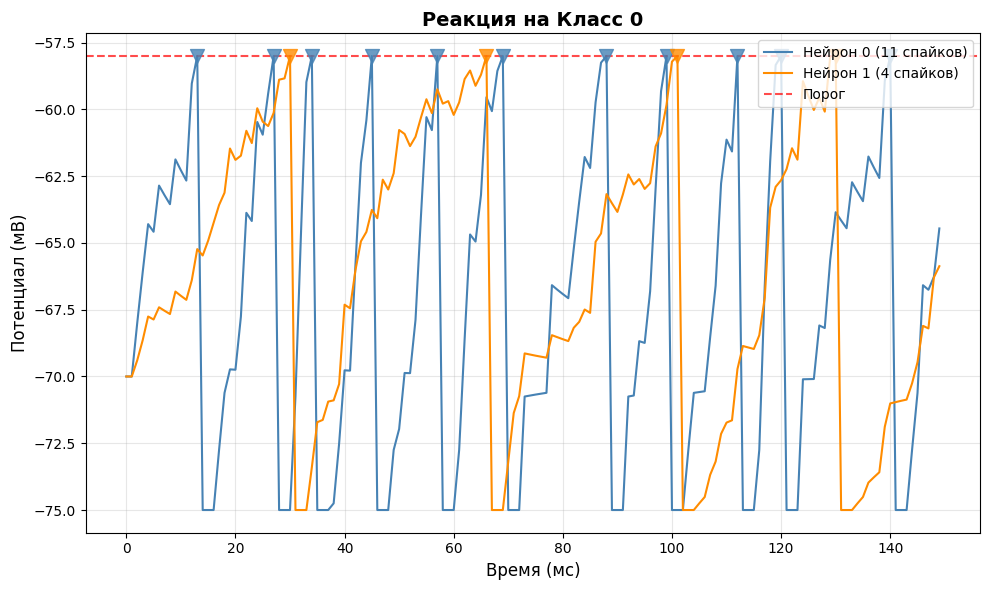

  Общее количество спайков: 17
  Энергия на спайк: 1.0 пДж
  Общее энергопотребление: 17.00 пДж = 0.017 нДж = 0.000017 мкДж
  Частота спайков: 56.67 спайков/сек/нейрон
  Плотность спайков: 0.0567 спайков/нейрон/мс


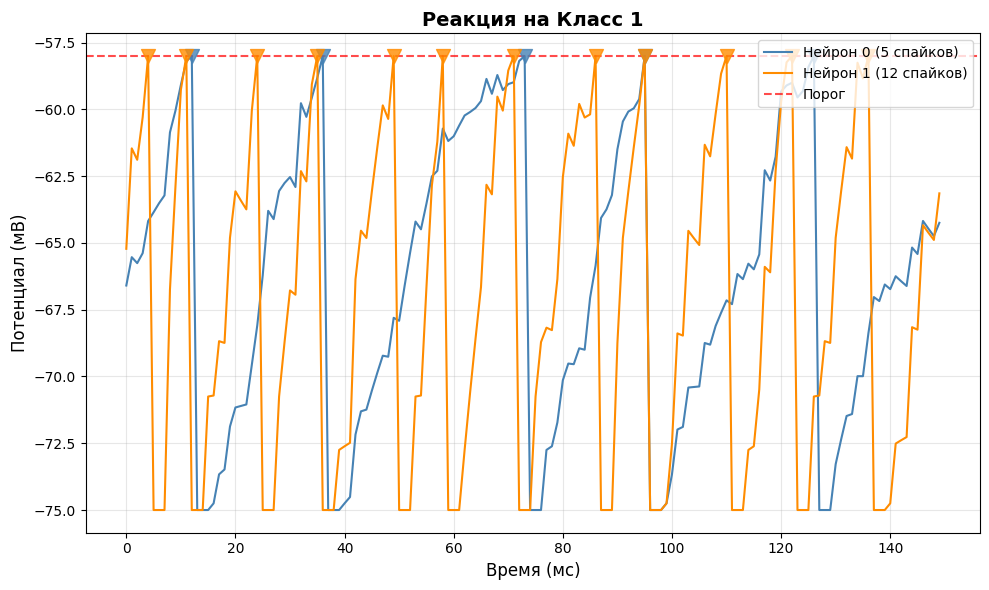

  Общее количество спайков: 29
  Энергия на спайк: 1.0 пДж
  Общее энергопотребление: 29.00 пДж = 0.029 нДж = 0.000029 мкДж
  Частота спайков: 96.67 спайков/сек/нейрон
  Плотность спайков: 0.0967 спайков/нейрон/мс


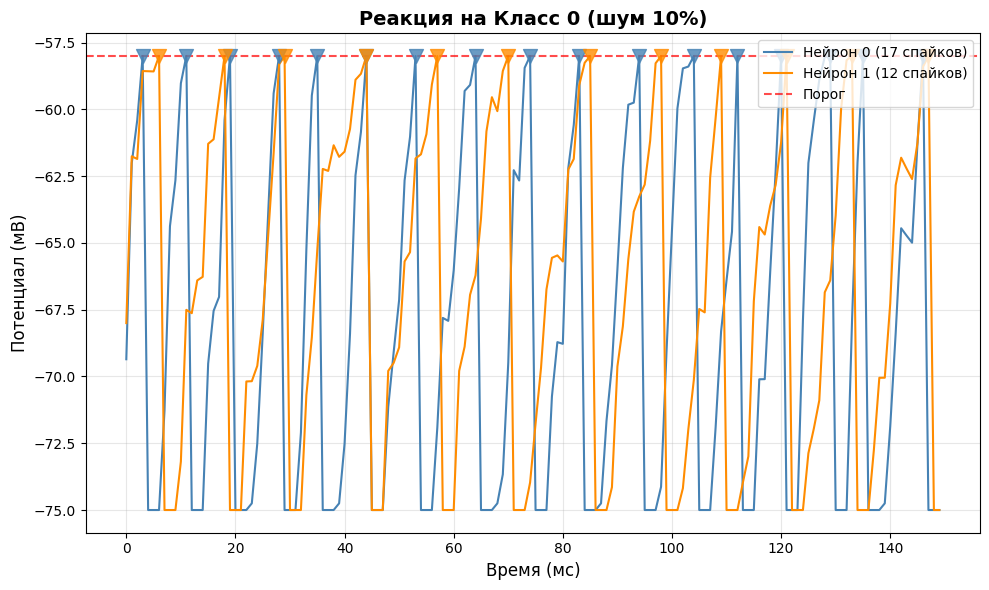

  Общее количество спайков: 34
  Энергия на спайк: 1.0 пДж
  Общее энергопотребление: 34.00 пДж = 0.034 нДж = 0.000034 мкДж
  Частота спайков: 113.33 спайков/сек/нейрон
  Плотность спайков: 0.1133 спайков/нейрон/мс


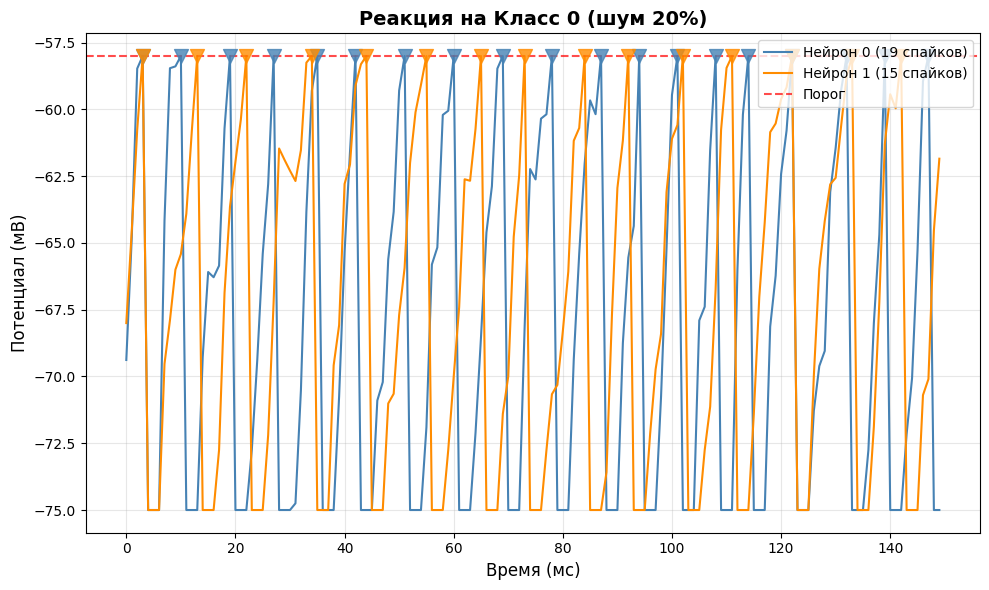

  Общее количество спайков: 41
  Энергия на спайк: 1.0 пДж
  Общее энергопотребление: 41.00 пДж = 0.041 нДж = 0.000041 мкДж
  Частота спайков: 136.67 спайков/сек/нейрон
  Плотность спайков: 0.1367 спайков/нейрон/мс


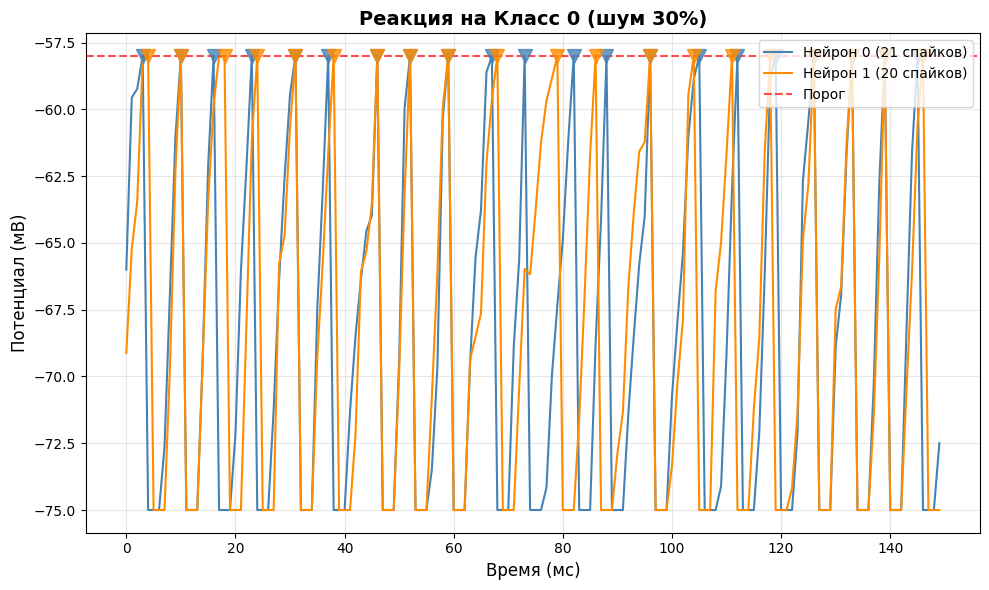

In [74]:
def analyze_energy_consumption(spike_times, num_neurons, sim_time, energy_per_spike_pj=1.0):
    total_spikes = sum(len(t) for t in spike_times)
    
    total_energy_pj = total_spikes * energy_per_spike_pj
    total_energy_nj = total_energy_pj / 1000
    total_energy_uj = total_energy_nj / 1000
    
    spike_rate = total_spikes / (num_neurons * sim_time / 1000)
    spike_density = total_spikes / (num_neurons * sim_time)
    
    print(f"  Общее количество спайков: {total_spikes}")
    print(f"  Энергия на спайк: {energy_per_spike_pj:.1f} пДж")
    print(f"  Общее энергопотребление: {total_energy_pj:.2f} пДж = {total_energy_nj:.3f} нДж = {total_energy_uj:.6f} мкДж")
    print(f"  Частота спайков: {spike_rate:.2f} спайков/сек/нейрон")
    print(f"  Плотность спайков: {spike_density:.4f} спайков/нейрон/мс")
    
    return {
        'total_spikes': total_spikes,
        'energy_pj': total_energy_pj,
        'energy_nj': total_energy_nj,
        'energy_uj': total_energy_uj,
        'spike_rate': spike_rate,
        'spike_density': spike_density
    }


def plot_neuron_response(network, input_spikes, label, dt, sim_time, noise_level=0.0):
    for neuron in network.output_neurons:
        neuron.reset()
    
    time_steps = len(input_spikes)
    t_range = np.arange(0, sim_time, dt)
    
    voltage_traces = [[] for _ in range(network.num_outputs)]
    spike_times = [[] for _ in range(network.num_outputs)]
    spike_counts = [0 for _ in range(network.num_outputs)]
    
    for step in range(time_steps):
        t = step * dt
        current_input = input_spikes[step]
        
        synaptic_currents = np.dot(network.weights, current_input)

        for j, neuron in enumerate(network.output_neurons):
            v_before = neuron.v
            
            is_spike = neuron.step(I_inj=synaptic_currents[j], dt=dt, t=t)
            

            if is_spike:
                voltage_traces[j].append(neuron.v_thresh)
                spike_times[j].append(t)
                spike_counts[j] += 1
            else:
                voltage_traces[j].append(neuron.v)
    analyze_energy_consumption(spike_times, network.num_outputs, sim_time)

    plt.figure(figsize=(10, 6))
    colors = ['steelblue', 'darkorange']
    
    for j in range(network.num_outputs):
        plt.plot(t_range, voltage_traces[j], color=colors[j], linewidth=1.5,
                label=f'Нейрон {j} ({spike_counts[j]} спайков)')
        
        if spike_times[j]:
            spike_ys = [network.output_neurons[0].v_thresh] * len(spike_times[j])
            plt.scatter(spike_times[j], spike_ys, color=colors[j], 
                       marker='v', s=100, zorder=5, alpha=0.8)
    
    plt.axhline(y=network.output_neurons[0].v_thresh, color='red', 
                linestyle='--', linewidth=1.5, alpha=0.7, label='Порог')
    
    plt.xlabel('Время (мс)', fontsize=12)
    plt.ylabel('Потенциал (мВ)', fontsize=12)
    
    noise_text = f' (шум {noise_level*100:.0f}%)' if noise_level > 0 else ''
    plt.title(f'Реакция на Класс {label}{noise_text}', fontsize=14, fontweight='bold')
    
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def test_with_noise(network, input_spikes, label, dt, sim_time, noise_levels=[0.0, 0.1, 0.2, 0.3]):
    results = []
    
    for noise_level in noise_levels:
        noisy_input = input_spikes.copy()
        
        mask = np.random.rand(*noisy_input.shape) < noise_level
        noisy_input[mask] = 1 - noisy_input[mask]
        
        prediction = network.predict(noisy_input, dt)
        correct = (prediction == label)
        
        results.append({
            'noise_level': noise_level,
            'prediction': prediction,
            'correct': correct
        })
               
        plot_neuron_response(network, noisy_input, label, dt, sim_time, noise_level)
    
    return results


if __name__ == "__main__":
    np.random.seed(42)
    DT, SIM_TIME = 1.0, 150
    
    network = SNNWithTeacher(num_inputs=10, num_outputs=2, inhibition_ratio=0.2)
    t_range = np.arange(0, SIM_TIME, DT)
    
    for epoch in range(10):
        lbl = epoch % 2
        network.train_epoch(make_pattern(lbl, t_range, DT), lbl, DT)
    
    plot_neuron_response(network, make_pattern(0, t_range, DT), label=0, dt=DT, sim_time=SIM_TIME)
    plot_neuron_response(network, make_pattern(1, t_range, DT), label=1, dt=DT, sim_time=SIM_TIME)
    
    test_with_noise(network, make_pattern(0, t_range, DT), label=0, 
                   dt=DT, sim_time=SIM_TIME, noise_levels=[0.1, 0.2, 0.3])

Анализ реакции спайковой нейронной сети на предъявление класса 0 с различным уровнем шума демонстрирует существенное влияние зашумленности данных на активность сети и ее энергопотребление. В условиях отсутствия шума сеть показывает четкую специализацию нейронов: первый нейрон генерирует 11 спайков при 4 спайках второго нейрона, что свидетельствует о корректной работе механизма распознавания образов и способности сети различать классы. Общее энергопотребление при этом минимально и составляет 15-17 пДж с плотностью спайков около 0.05 спайков/нейрон/мс. Однако с увеличением уровня шума наблюдается закономерный рост спайковой активности: при 10% шуме количество спайков возрастает до 29, при 20% — до 34, а при 30% шуме достигает 41 спайка, что соответствует увеличению энергопотребления почти в три раза по сравнению с чистым сигналом. Особенно критичным является то, что при 30% уровне шума сеть теряет способность к четкой классификации: первый и второй нейроны генерируют практически одинаковое количество спайков (21 и 20 соответственно), что делает невозможным однозначное определение класса. Это подтверждает, что хотя SNN демонстрируют высокую энергоэффективность при работе с качественными данными, их устойчивость к шуму ограничена, и при значительном уровне зашумленности как точность классификации, так и энергоэффективность существенно снижаются из-за избыточной спайковой активности.